Modeling siltuximab in the absorption and delivery components of ADME PK analysis

In [55]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})


In [42]:
# Updated PK parameters for siltuximab
k_ABS = 1  # Absorption rate constant [1/hour] (immediate for IV mAbs)
k_CP = 0.02   # Rate constant from central to peripheral compartment [1/hour]
k_PC = 0.01   # Rate constant from peripheral to central compartment [1/hour]
k_Celim = 0.001  # Elimination rate constant [1/hour] (long half-life ~10 days)
k_CT = 0.001  # Rate constant for tumor homing [1/hour]
k_TC = 0.01  # Rate constant for leaving the tumor compartment [1/hour]
k_CL = 0.005  # Rate constant for accumulation in the liver [1/hour]
k_TMEelim = 0.01  # TME effects reducing persistence in the tumor [1/hour]

V_CENTRAL = 3.0  # Volume of central compartment [Liters] (plasma volume for mAbs)
V_TUMOR = 0.1    # Volume of tumor compartment [Liters]
dose = 200       # Initial dose [mg] (typical dose for siltuximab)
MW = 145000      # Molecular weight of siltuximab [g/mol]
AVOGADRO = 6.022e23  # Avogadro's number [molecules/mol]

# Convert dose to molar units (moles)
dose_moles = dose / MW  # [moles]
dose_molecules = dose_moles * AVOGADRO  # [molecules]

In [24]:
def pk_model_tmdd(y, t, k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim):
    # y = [Dosing, Central, Peripheral, Tumor, Liver]
    dAdt = -k_ABS * y[0]  # Dosing compartment
    dCdt = (k_ABS * y[0] / V_CENTRAL) - (k_CP + k_CT + k_CL + k_Celim) * y[1] \
           + k_PC * y[2] + k_TC * y[3]  # Central compartment
    dPdt = k_CP * y[1] - k_PC * y[2]  # Peripheral compartment
    dTdt = k_CT * y[1] - (k_TC + k_TMEelim) * y[3]  # Tumor compartment
    dLiverdt = k_CL * y[1]  # Liver compartment
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt]

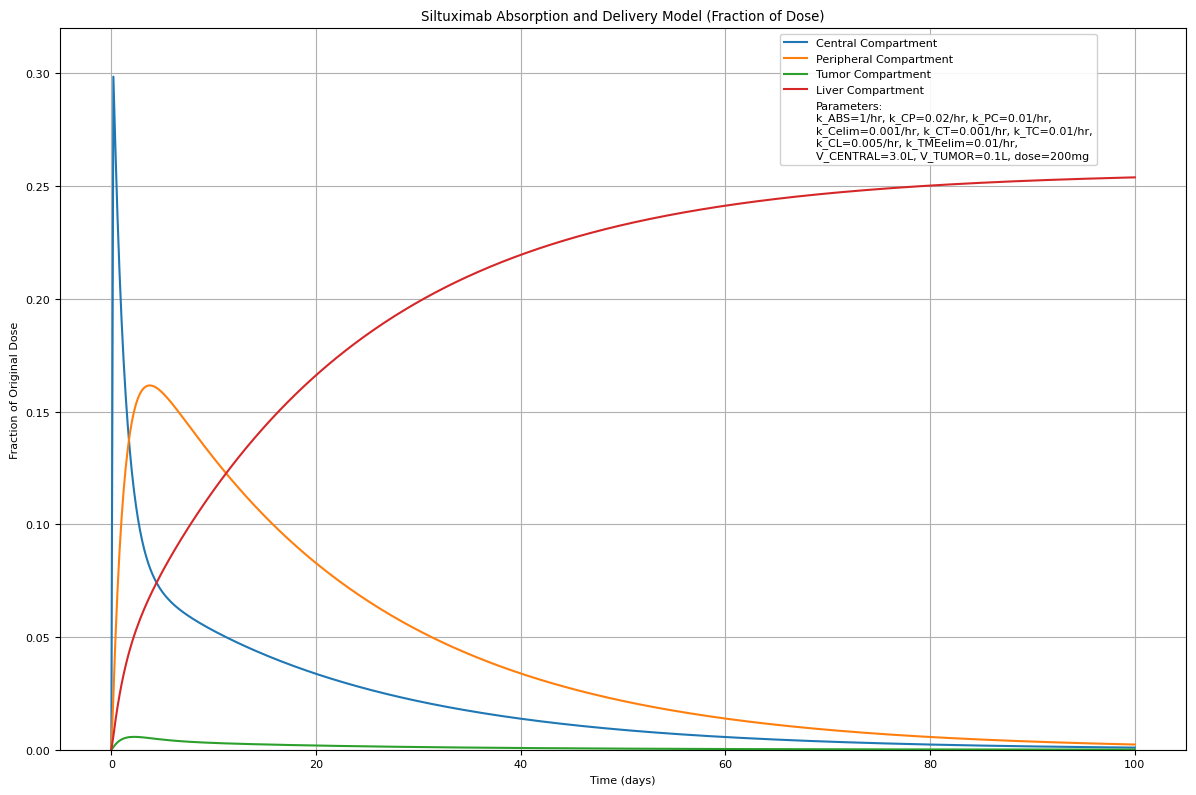

In [62]:
t = np.linspace(0, 2400, 500)  # Simulate over 48 hours with fine resolution
# Initial conditions: [Dosing, Central, Peripheral, Tumor, Liver]
y0_tmdd = [dose_moles, 0, 0, 0, 0]  # Initial conditions

# Solve ODE with TMDD
solution_tmdd = odeint(pk_model_tmdd, y0_tmdd, t,
                       args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim),
                       atol=1e-12, rtol=1e-9)

# Plot results
# plt.figure(figsize=(12, 8))
# plt.plot(t, solution_tmdd[:, 1], label='Central Compartment')
# plt.plot(t, solution_tmdd[:, 2], label='Peripheral Compartment')
# plt.plot(t, solution_tmdd[:, 3], label='Tumor Compartment')
# plt.plot(t, solution_tmdd[:, 4], label='Liver Compartment')
# plt.xlabel('Time (hours)')
# plt.ylabel('Concentration')
# plt.title('Siltuximab PK Model with TMDD')
# plt.legend()
# plt.grid(True)
# plt.show()

# PLOT IN DAYS
t_days = t / 24  # Convert time from hours to days

# Calculate the fraction of the original dose for each compartment
fraction_dose_central = solution_tmdd[:, 1] / dose_moles  # Central compartment
fraction_dose_peripheral = solution_tmdd[:, 2] / dose_moles  # Peripheral compartment
fraction_dose_tumor = solution_tmdd[:, 3] / dose_moles  # Tumor compartment
fraction_dose_liver = solution_tmdd[:, 4] / dose_moles  # Liver compartment

# Plot results in DAYS
plt.figure(figsize=(12, 8))
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr, k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}mg"
)
plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Update labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('Siltuximab Absorption and Delivery Model (Fraction of Dose)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.ylim((0.00, 0.32))

plt.grid(True)
plt.tight_layout()

plt.show()

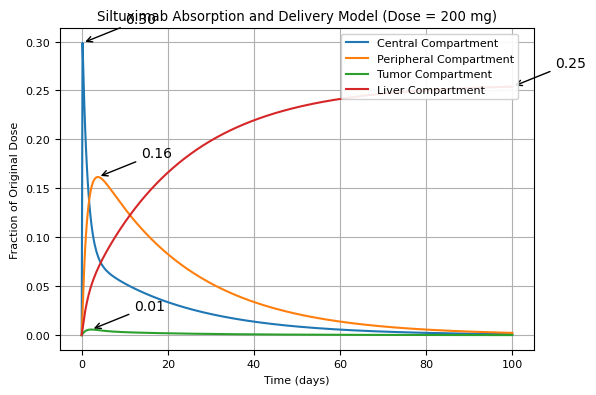

k_ABS=1/hr, k_CP=0.02/hr, k_PC=0.01/hr,
k_Celim=0.001/hr, k_CT=0.001/hr, k_TC=0.01/hr,
k_CL=0.005/hr, k_TMEelim=0.01/hr,
V_CENTRAL=3.0L, V_TUMOR=0.1L, dose=200mg


In [ ]:
# ANNOTATED PEAKS
# Calculate the peak values and their corresponding times
peak_central = np.max(fraction_dose_central)
time_peak_central = t_days[np.argmax(fraction_dose_central)]

peak_peripheral = np.max(fraction_dose_peripheral)
time_peak_peripheral = t_days[np.argmax(fraction_dose_peripheral)]

peak_tumor = np.max(fraction_dose_tumor)
time_peak_tumor = t_days[np.argmax(fraction_dose_tumor)]

peak_liver = np.max(fraction_dose_liver)
time_peak_liver = t_days[np.argmax(fraction_dose_liver)]

# Plot results in DAYS
plt.figure(figsize=(6, 4))
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Annotate the peaks
plt.annotate(f'{peak_central:.2f}', xy=(time_peak_central, peak_central), 
             xytext=(time_peak_central + 10, peak_central + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate(f'{peak_peripheral:.2f}', xy=(time_peak_peripheral, peak_peripheral), 
             xytext=(time_peak_peripheral + 10, peak_peripheral + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate(f'{peak_tumor:.2f}', xy=(time_peak_tumor, peak_tumor), 
             xytext=(time_peak_tumor + 10, peak_tumor + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate(f'{peak_liver:.2f}', xy=(time_peak_liver, peak_liver), 
             xytext=(time_peak_liver + 10, peak_liver + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr, k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}mg"
)
# plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Update labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('Siltuximab Absorption and Delivery Model (Dose = 200 mg)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()
plt.savefig('Siltuximab_100days.jpg', format='jpeg', dpi=300)

plt.show()
print(parameters_text)

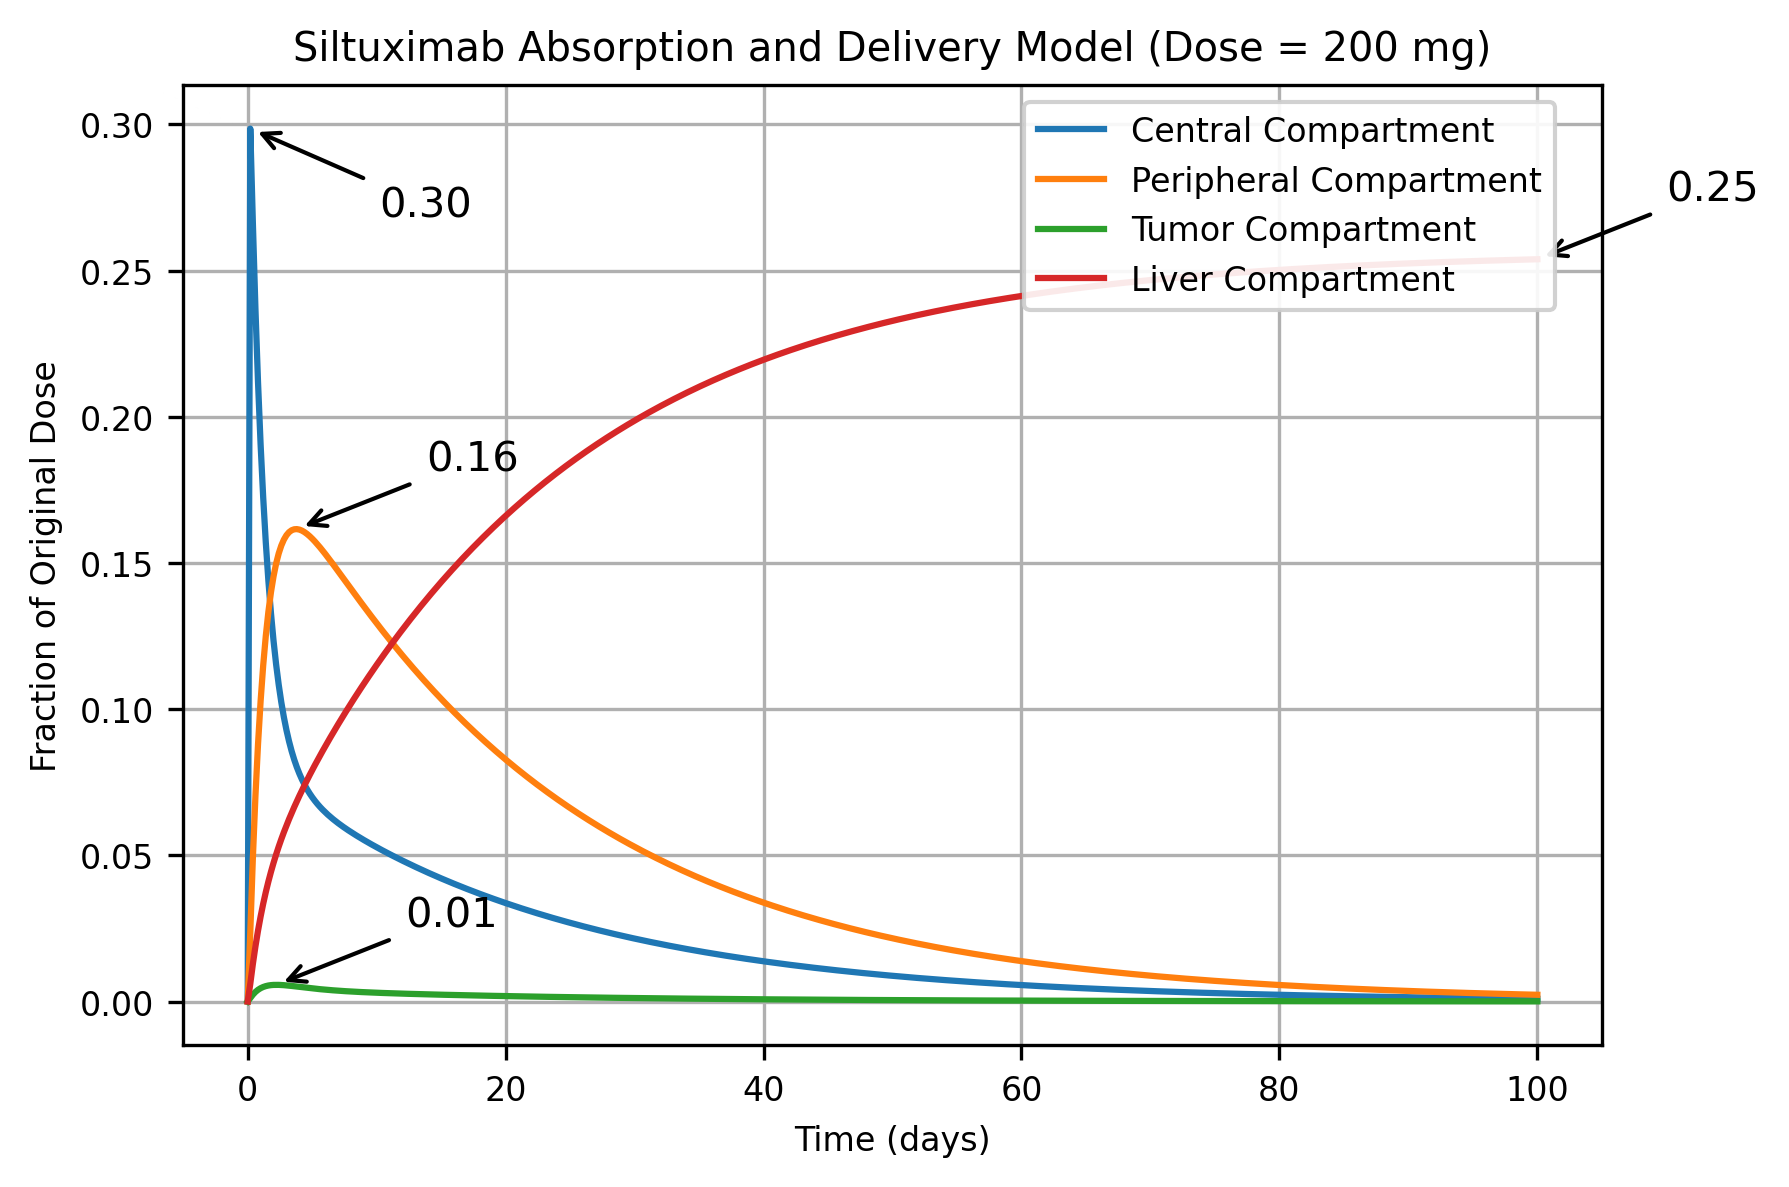

k_ABS=1/hr, k_CP=0.02/hr, k_PC=0.01/hr,
k_Celim=0.001/hr, k_CT=0.001/hr, k_TC=0.01/hr,
k_CL=0.005/hr, k_TMEelim=0.01/hr,
V_CENTRAL=3.0L, V_TUMOR=0.1L, dose=200mg


In [63]:
# ANNOTATED PEAKS
# Calculate the peak values and their corresponding times
peak_central = np.max(fraction_dose_central)
time_peak_central = t_days[np.argmax(fraction_dose_central)]

peak_peripheral = np.max(fraction_dose_peripheral)
time_peak_peripheral = t_days[np.argmax(fraction_dose_peripheral)]

peak_tumor = np.max(fraction_dose_tumor)
time_peak_tumor = t_days[np.argmax(fraction_dose_tumor)]

peak_liver = np.max(fraction_dose_liver)
time_peak_liver = t_days[np.argmax(fraction_dose_liver)]

# Plot results in DAYS
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Annotate the peaks with adjusted positions to avoid overlap
# Central Compartment
plt.annotate(f'{peak_central:.2f}', xy=(time_peak_central, peak_central), 
             xytext=(time_peak_central + 10, peak_central - 0.03),  # Adjusted downward to avoid title overlap
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Peripheral Compartment
plt.annotate(f'{peak_peripheral:.2f}', xy=(time_peak_peripheral, peak_peripheral), 
             xytext=(time_peak_peripheral + 10, peak_peripheral + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Tumor Compartment
plt.annotate(f'{peak_tumor:.2f}', xy=(time_peak_tumor, peak_tumor), 
             xytext=(time_peak_tumor + 10, peak_tumor + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Liver Compartment
plt.annotate(f'{peak_liver:.2f}', xy=(time_peak_liver, peak_liver), 
             xytext=(time_peak_liver + 10, peak_liver + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr, k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}mg"
)
# plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Update labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('Siltuximab Absorption and Delivery Model (Dose = 200 mg)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()
plt.savefig('Systems/April6_Plots/Siltuximab_100days.jpg', format='jpeg', dpi=300)

plt.show()
print(parameters_text)

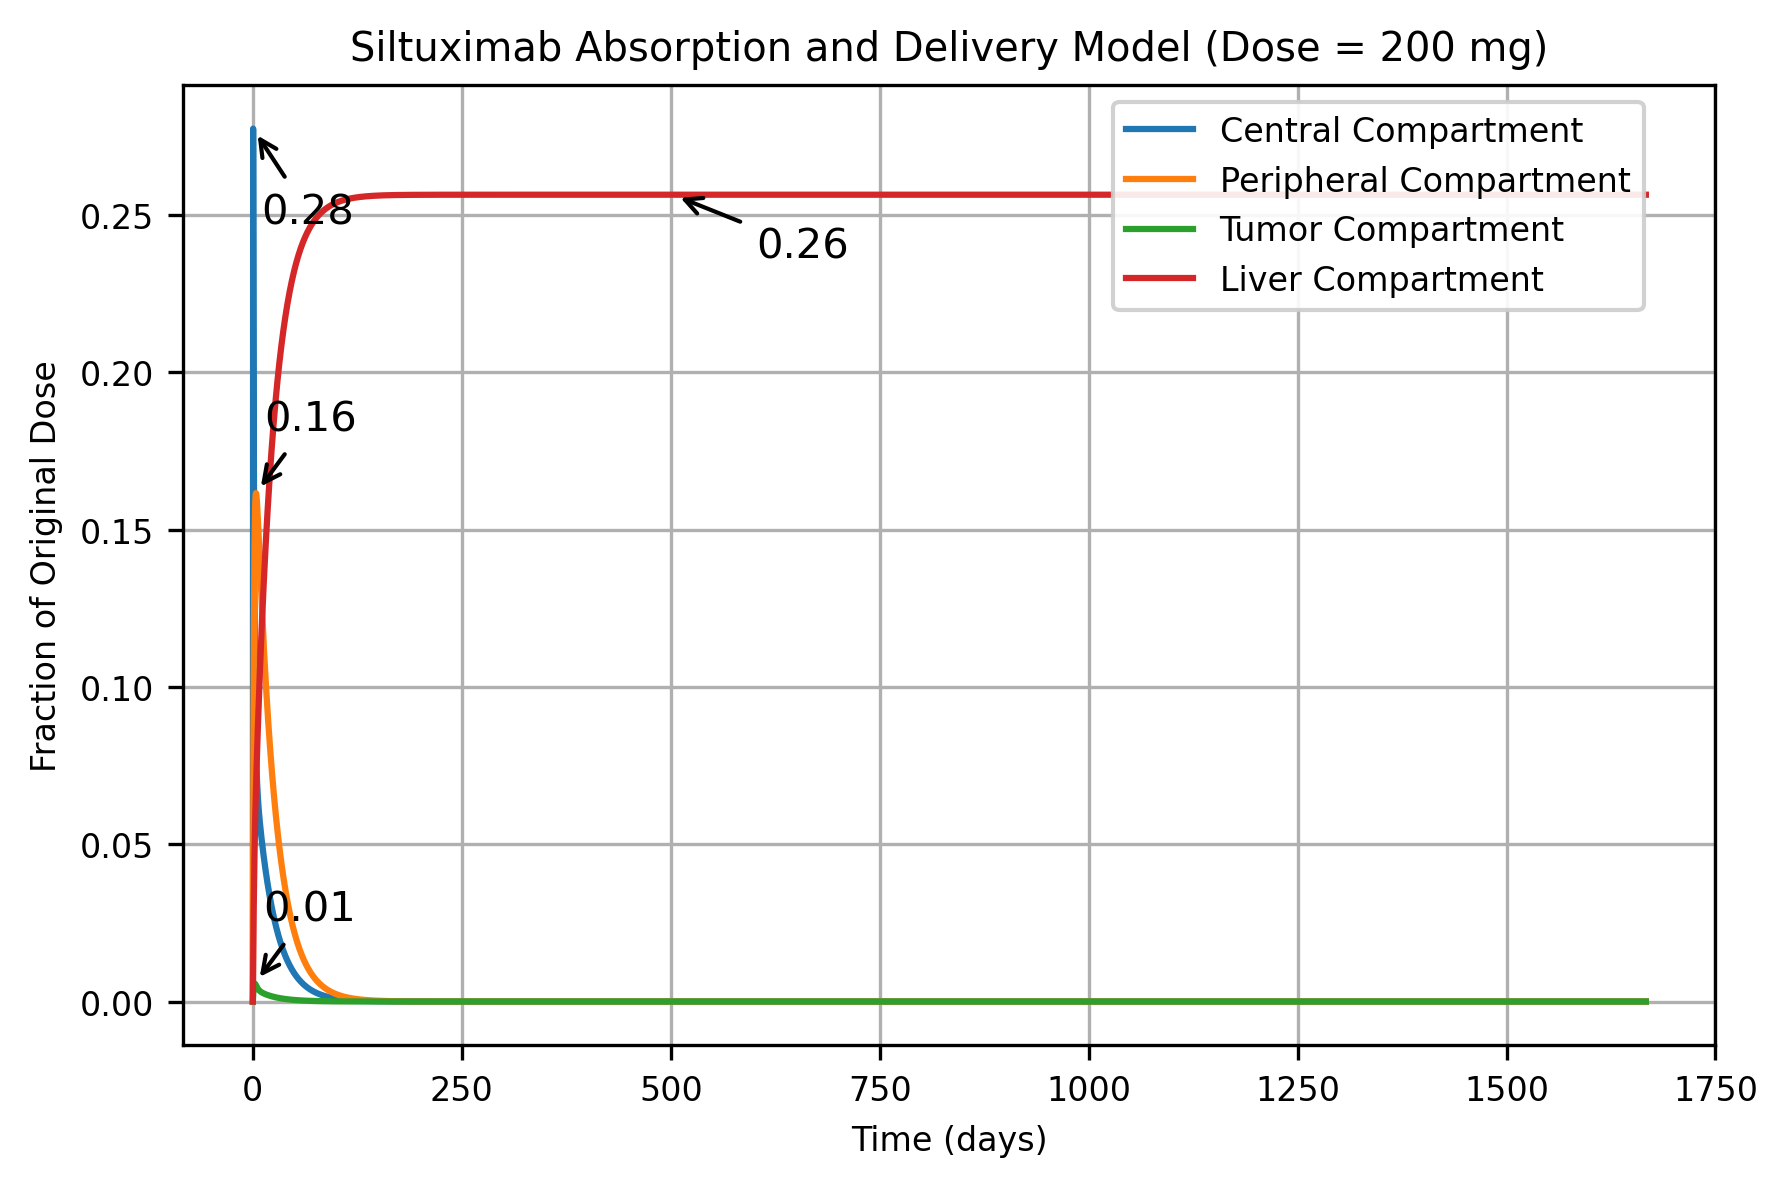

k_ABS=1/hr, k_CP=0.02/hr, k_PC=0.01/hr,
k_Celim=0.001/hr, k_CT=0.001/hr, k_TC=0.01/hr,
k_CL=0.005/hr, k_TMEelim=0.01/hr,
V_CENTRAL=3.0L, V_TUMOR=0.1L, dose=200mg


In [71]:
t = np.linspace(0, 40000, 5000)  # Simulate over 48 hours with fine resolution
# Initial conditions: [Dosing, Central, Peripheral, Tumor, Liver]
y0_tmdd = [dose_moles, 0, 0, 0, 0]  # Initial conditions

# Solve ODE with TMDD
solution_tmdd = odeint(pk_model_tmdd, y0_tmdd, t,
                       args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim),
                       atol=1e-12, rtol=1e-9)

# PLOT IN DAYS
t_days = t / 24  # Convert time from hours to days

# Calculate the fraction of the original dose for each compartment
fraction_dose_central = solution_tmdd[:, 1] / dose_moles  # Central compartment
fraction_dose_peripheral = solution_tmdd[:, 2] / dose_moles  # Peripheral compartment
fraction_dose_tumor = solution_tmdd[:, 3] / dose_moles  # Tumor compartment
fraction_dose_liver = solution_tmdd[:, 4] / dose_moles  # Liver compartment

# ANNOTATED PEAKS
# Calculate the peak values and their corresponding times
peak_central = np.max(fraction_dose_central)
time_peak_central = t_days[np.argmax(fraction_dose_central)]

peak_peripheral = np.max(fraction_dose_peripheral)
time_peak_peripheral = t_days[np.argmax(fraction_dose_peripheral)]

peak_tumor = np.max(fraction_dose_tumor)
time_peak_tumor = t_days[np.argmax(fraction_dose_tumor)]

peak_liver = np.max(fraction_dose_liver)
time_peak_liver = t_days[np.argmax(fraction_dose_liver)]

# Plot results in DAYS
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Annotate the peaks with adjusted positions to avoid overlap
# Central Compartment
plt.annotate(f'{peak_central:.2f}', xy=(time_peak_central, peak_central), 
             xytext=(time_peak_central + 10, peak_central - 0.03),  # Adjusted downward to avoid title overlap
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Peripheral Compartment
plt.annotate(f'{peak_peripheral:.2f}', xy=(time_peak_peripheral, peak_peripheral), 
             xytext=(time_peak_peripheral + 10, peak_peripheral + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Tumor Compartment
plt.annotate(f'{peak_tumor:.2f}', xy=(time_peak_tumor, peak_tumor), 
             xytext=(time_peak_tumor + 10, peak_tumor + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Liver Compartment
plt.annotate(f'{peak_liver:.2f}', xy=(time_peak_tumor + 500, peak_liver), 
             xytext=(time_peak_tumor + 600, peak_liver - 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr, k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}mg"
)
# plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Update labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('Siltuximab Absorption and Delivery Model (Dose = 200 mg)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()
plt.savefig('Systems/April6_Plots/Siltuximab_1700days.jpg', format='jpeg', dpi=300)

plt.show()
print(parameters_text)

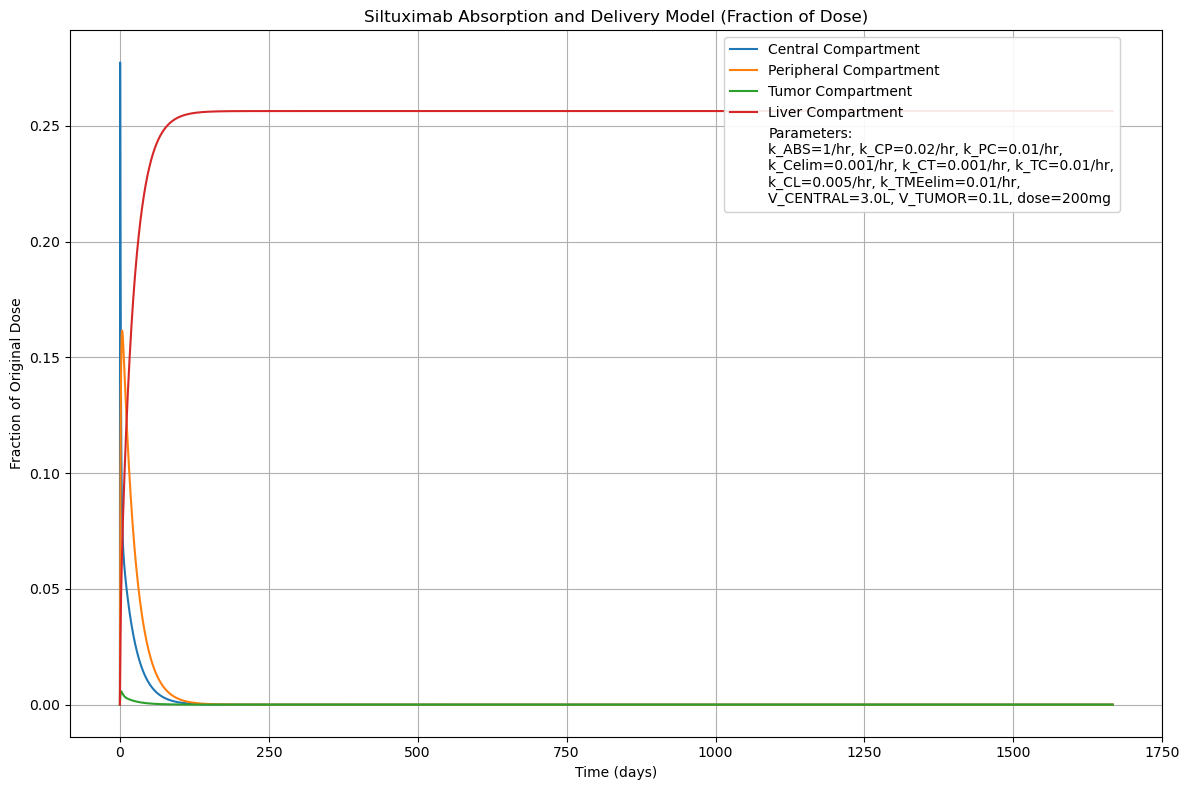

In [44]:
t = np.linspace(0, 40000, 5000)  # Simulate over 48 hours with fine resolution
# Initial conditions: [Dosing, Central, Peripheral, Tumor, Liver]
y0_tmdd = [dose_moles, 0, 0, 0, 0]  # Initial conditions

# Solve ODE with TMDD
solution_tmdd = odeint(pk_model_tmdd, y0_tmdd, t,
                       args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim),
                       atol=1e-12, rtol=1e-9)

# Plot results
# plt.figure(figsize=(12, 8))
# plt.plot(t, solution_tmdd[:, 1], label='Central Compartment')
# plt.plot(t, solution_tmdd[:, 2], label='Peripheral Compartment')
# plt.plot(t, solution_tmdd[:, 3], label='Tumor Compartment')
# plt.plot(t, solution_tmdd[:, 4], label='Liver Compartment')
# plt.xlabel('Time (hours)')
# plt.ylabel('Concentration')
# plt.title('Siltuximab PK Model with TMDD')
# plt.legend()
# plt.grid(True)
# plt.show()

# PLOT IN DAYS
t_days = t / 24  # Convert time from hours to days

# Calculate the fraction of the original dose for each compartment
fraction_dose_central = solution_tmdd[:, 1] / dose_moles  # Central compartment
fraction_dose_peripheral = solution_tmdd[:, 2] / dose_moles  # Peripheral compartment
fraction_dose_tumor = solution_tmdd[:, 3] / dose_moles  # Tumor compartment
fraction_dose_liver = solution_tmdd[:, 4] / dose_moles  # Liver compartment

# Plot results in DAYS
plt.figure(figsize=(12, 8))
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr, k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}mg"
)
plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Update labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('Siltuximab Absorption and Delivery Model (Fraction of Dose)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()

plt.show()

In [45]:
max_tumor_index = np.argmax(solution_tmdd[:,3])
time_of_max_tumor = t[max_tumor_index] # in hours
max_tumor_concentration = solution_tmdd[max_tumor_index, 3]

print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor:.2f} hours")
print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor/24:.2f} days")

print(f"Maximum Tumor Concentration: {max_tumor_concentration:.2e} Molar")

Time of Maximum Tumor Concentration: 56.01 hours
Time of Maximum Tumor Concentration: 2.33 days
Maximum Tumor Concentration: 7.86e-06 Molar
